# Correlation between ICOS data and satellite CO/CO2 data

This notebook analyses the correlations between in-situ data and satellite data. 
* [1 - ICOS in-situ data](#icos_data)
* [2 - Satellite data](#satellite_data)
* [3 - Correlation](#correlation)

In [1]:
!pip install icoscp --quiet
!pip install ipygee --quiet

In [2]:
# python lib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm import tqdm

# Import module:
import sys

# Set path to ICOS tools:
sys.path.insert(0,'/data/project/pytools')

# Import ICOS tools:
from icoscp.sparql import sparqls
#from icoscp.cpb.cpbinfile import CpBinFile 
from icoscp.cpb.dobj import Dobj # @Alex ?
from icoscp.sparql.runsparql import RunSparql
from icoscp.station import station

In [3]:
# Choose which pollutant to analyse between "co" and "co2"
pollutant = "co2" #"co2"

## <a id='icos_data'></a> 1. ICOS in-situ data

In [4]:
stations = station.getIdList()
stations

uri      id  \
40   http://meta.icos-cp.eu/resources/stations/ES_S...  SE-Sto   
35   http://meta.icos-cp.eu/resources/stations/ES_I...  IT-Noe   
105  http://meta.icos-cp.eu/resources/stations/ES_U...  UK-AMo   
48   http://meta.icos-cp.eu/resources/stations/ES_F...  FR-Aur   
131  http://meta.icos-cp.eu/resources/stations/OS_1199    1199   
..                                                 ...     ...   
132  http://meta.icos-cp.eu/resources/stations/ES_C...  CD-Ygb   
101  http://meta.icos-cp.eu/resources/stations/ES_G...  GL-ZaF   
100  http://meta.icos-cp.eu/resources/stations/ES_G...  GL-ZaH   
11    http://meta.icos-cp.eu/resources/stations/AS_ZEP     ZEP   
120   http://meta.icos-cp.eu/resources/stations/AS_ZSF     ZSF   

                             name country        lat         lon elevation  \
40     Abisko-Stordalen Palsa Bog      SE   68.35594   19.045208   351.893   
35   Arca di Noe - Le Prigionette      IT  40.606174     8.15117      25.0   
105              Auchencorth Moss      GB  55.792545  -3.2436917     270.0   
48                         Aurade      FR   43.54965    1.106103     250.0   
131          BE-FOS-Thornton Buoy      BE   51.57989    2.993217      None   
..                            ...     ...        ...         ...       ...   
132                      Yangambi      CD   0.814473   24.502525      None   
101                Zackenberg Fen      GL   74.48152  -20.555773      38.0   
100               Zackenberg Gras      GL   74.47328    -20.5503      48.0   
11                       Zeppelin      NO    78.9072     11.8867     474.0   
120                     Zugspitze      DE    47.4165     10.9796    2666.0   

    project theme  
40     ICOS    ES  
35     ICOS    ES  
105    ICOS    ES  
48     ICOS    ES  
131    ICOS    OS  
..      ...   ...  
132    ICOS    ES  
101    ICOS    ES  
100    ICOS    ES  
11     ICOS    AS  
120    ICOS    AS  

[137 rows x 9 columns]

In [5]:
if pollutant == "co2":   
    myStation = station.get("CMN")
    icos_station = myStation.name
    
    lat = myStation.info()['lat']
    lon = myStation.info()['lon']

    mySpecLabel = 'ICOS ATC CO2 Release' # 'CH4/CO/CO2'
    specie = "co" #'co2/ch4/co/co2'

    level2Data = myStation.data(level=2)
    level2Data_spec = level2Data[level2Data['specLabel'] == mySpecLabel]
    pid = level2Data_spec.loc[pd.to_numeric(level2Data_spec['samplingheight']).idxmax(), 'dobj']

    f = Dobj(pid)
    icos_df = f.getColumns()
    
    info = f.info[1]
    unit = info.loc[info["colName"]=="co2"].unit.values[0]
    
    # get dates
    init_date_ICOS = str(icos_df['TIMESTAMP'].min())[0:10]
    end_date_ICOS = str(icos_df['TIMESTAMP'].max())[0:10]
    
    icos_df = icos_df.set_index("TIMESTAMP").resample('D').mean()
    icos_df = icos_df.drop(["Stdev", "NbPoints"], axis=1)
    icos_df = icos_df.reset_index().rename(columns={"co2":"icos_co2", "TIMESTAMP":"time"})
    icos_df

elif pollutant == "co":
    dobj = Dobj('https://meta.icos-cp.eu/objects/vJMyWauvejIDlLhBhJJ-FSs5')
    icos_station = dobj.station
    lat = dobj.lat
    lon = dobj.lon
    icos_df = dobj.data.drop(["Stdev", "NbPoints", "Flag"], axis=1)
    
    info = dobj.info[1]
    unit = info.loc[info["colName"]=="co"].unit.values[0]
    
    # get dates
    init_date_ICOS = str(icos_df['TIMESTAMP'].min())[0:10]
    end_date_ICOS = str(icos_df['TIMESTAMP'].max())[0:10]
    
    icos_df = icos_df.rename(columns={"co":"icos_co", "TIMESTAMP":"time"})
    icos_df

In [39]:
end_date_ICOS

'2021-01-31'

<AxesSubplot:xlabel='time'>

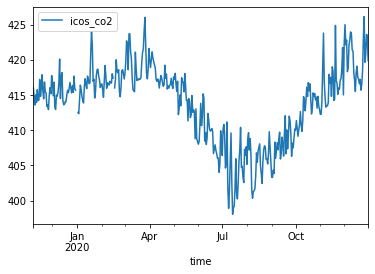

In [37]:
icos_df.set_index("time").plot()

<AxesSubplot:xlabel='time'>

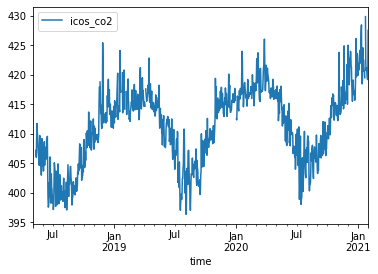

In [6]:
icos_df.set_index("time").plot()

## 2. <a id='satellite_data'></a> Satellite data

In [6]:
import fsspec
import xarray as xr

if pollutant=="co2": #(mg/m3)
    repo = "greenhouse-gases/greenhouse_gases.zarr"
elif pollutant=="co":
    repo = "air-quality/air_quality_all.zarr"
    
mapper = fsspec.get_mapper(
    "s3://dev/sti-storage/" + repo, 
    key= "2b19ac88b45e46c8822b276cb91e9ce0", 
    secret= "634f4c112a72489d8560c4bd74a20aca", 
    client_kwargs=dict(endpoint_url= "https://s3.waw2-1.cloudferro.com")
) 
ds = xr.open_zarr(mapper)
ds

<xarray.Dataset>
Dimensions:    (time: 216, latitude: 241, longitude: 480)
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    ch4        (time, latitude, longitude) float64 dask.array<chunksize=(27, 61, 120), meta=np.ndarray>
    co2        (time, latitude, longitude) float64 dask.array<chunksize=(27, 61, 120), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-31 14:29:26 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [8]:
import xarray as xr
ds = xr.open_dataset("data/levtype_pl.nc")
ds

<xarray.Dataset>
Dimensions:    (longitude: 94, latitude: 62, time: 3368)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.25 -23.5 ... 43.25 44.0 44.75
  * latitude   (latitude) float32 71.75 71.0 70.25 69.5 ... 27.5 26.75 26.0
  * time       (time) datetime64[ns] 2019-11-07 ... 2020-12-31T09:00:00
Data variables:
    co2        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-02 04:47:59 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [9]:
sat_df = ds["co2"].sel(latitude=lat, longitude=lon, method="nearest").to_dataframe()
sat_df

longitude  latitude       co2
time                                              
2019-11-07 00:00:00       11.0      44.0  0.000667
2019-11-07 12:00:00       11.0      44.0  0.000633
2019-11-07 15:00:00       11.0      44.0  0.000630
2019-11-07 18:00:00       11.0      44.0  0.000657
2019-11-07 21:00:00       11.0      44.0  0.000663
...                        ...       ...       ...
2020-12-31 18:00:00       11.0      44.0  0.000657
2020-12-31 21:00:00       11.0      44.0  0.000666
2020-12-31 03:00:00       11.0      44.0  0.000689
2020-12-31 06:00:00       11.0      44.0  0.000703
2020-12-31 09:00:00       11.0      44.0  0.000681

[3368 rows x 3 columns]

In [7]:
if pollutant=="co2":
    sat_df = ds["co2"].sel(latitude=lat, longitude=lon, method="nearest").to_dataframe()    
elif pollutant=="co":
    ds = ds.assign_coords(longitude=([lon-360 if lon>180 else lon for lon in ds.longitude]))
    sat_df = ds["co_conc"].sel(latitude=lat, longitude=lon, method="nearest").to_dataframe()

In [26]:
sat_df.drop(["latitude","longitude"], axis=1, inplace=True)
sat_df

In [28]:
sat_df = sat_df.sort_values(by="time")
sat_df[:24]

time   sat_co2
0  2019-11-07 00:00:00  0.000667
5  2019-11-07 03:00:00  0.000678
6  2019-11-07 06:00:00  0.000686
7  2019-11-07 09:00:00  0.000652
1  2019-11-07 12:00:00  0.000633
2  2019-11-07 15:00:00  0.000630
3  2019-11-07 18:00:00  0.000657
4  2019-11-07 21:00:00  0.000663
8  2019-11-08 00:00:00  0.000674
13 2019-11-08 03:00:00  0.000656
14 2019-11-08 06:00:00  0.000647
15 2019-11-08 09:00:00  0.000637
9  2019-11-08 12:00:00  0.000627
10 2019-11-08 15:00:00  0.000627
11 2019-11-08 18:00:00  0.000646
12 2019-11-08 21:00:00  0.000652
16 2019-11-09 00:00:00  0.000647
21 2019-11-09 03:00:00  0.000658
22 2019-11-09 06:00:00  0.000674
23 2019-11-09 09:00:00  0.000641
17 2019-11-09 12:00:00  0.000628
18 2019-11-09 15:00:00  0.000628
19 2019-11-09 18:00:00  0.000669
20 2019-11-09 21:00:00  0.000709

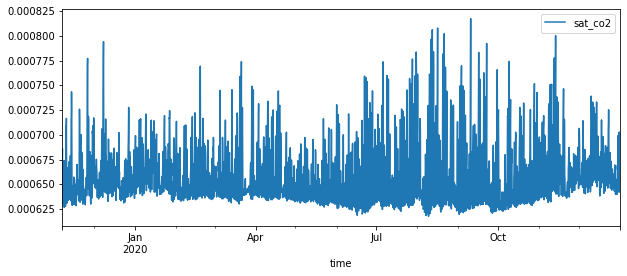

In [31]:
fig = sat_df.set_index("time").plot(figsize=(10,4))

In [32]:
sat_df.reset_index(inplace=True)
mask = (sat_df['time'] >= init_date_ICOS) & (sat_df['time'] <= end_date_ICOS)
sat_df = sat_df.loc[mask]
sat_df

index                time   sat_co2
0         0 2019-11-07 00:00:00  0.000667
1         5 2019-11-07 03:00:00  0.000678
2         6 2019-11-07 06:00:00  0.000686
3         7 2019-11-07 09:00:00  0.000652
4         1 2019-11-07 12:00:00  0.000633
...     ...                 ...       ...
3363   3367 2020-12-31 09:00:00  0.000681
3364   3361 2020-12-31 12:00:00  0.000645
3365   3362 2020-12-31 15:00:00  0.000642
3366   3363 2020-12-31 18:00:00  0.000657
3367   3364 2020-12-31 21:00:00  0.000666

[3368 rows x 3 columns]

In [13]:
if pollutant=="co2":
    sat_df = sat_df.rename(columns={f"{pollutant}":f"sat_{pollutant}"})
elif pollutant=="co":
    sat_df = sat_df.rename(columns={"co_conc":f"sat_{pollutant}"})
    sat_df.drop(["level"], axis=1, inplace=True)

In [14]:
sat_df.to_csv("satellite_co2_data.csv")

In [15]:
init_date_sat = str(sat_df['time'].min())[0:10]
end_date_sat = str(sat_df['time'].max())[0:10]

## <a id='correlation'></a> 3. Correlation ICOS / satellite

In [33]:
icos_df = icos_df.reset_index()
mask = (icos_df['time'] >= init_date_sat) & (icos_df['time'] <= end_date_sat)
icos_df = icos_df.loc[mask]
icos_df.drop(["index"], axis=1, inplace=True)
# icos_df.drop(["level_0"], axis=1, inplace=True)

In [34]:
pollutant_df = sat_df.merge(icos_df)
pollutant_df = pollutant_df.set_index("time")

In [35]:
# Normalize to compare despite different units 
df = pollutant_df.copy()
normalized_df=(df-df.min())/(df.max()-df.min())

In [36]:
import plotly.express as px

px.line(normalized_df)

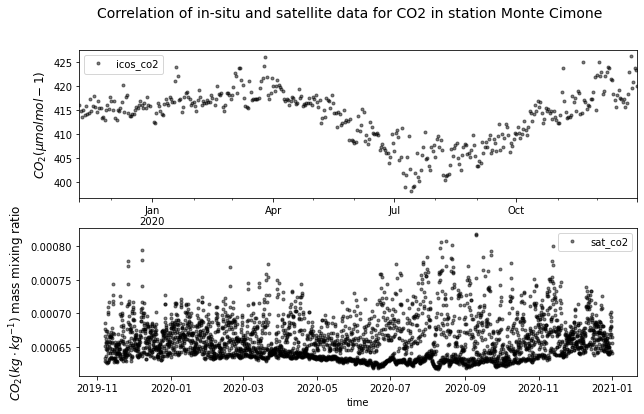

In [20]:
fig, axs = plt.subplots(nrows=2, figsize=(10,6))
icos_df.set_index("time").plot(marker='.', alpha=0.5, color='k', linestyle='None', subplots=True, ax=axs[0])
sat_df.set_index("time").plot(marker='.', alpha=0.5, color='k', linestyle='None', subplots=True, ax=axs[1])

if pollutant=="co2":
    axs[0].set_ylabel(fr'$CO_2 ({unit})$', fontsize=12)
    axs[1].set_ylabel(r'$CO_2 (kg \cdot kg^{-1})$ mass mixing ratio', fontsize=12)
elif pollutant=="co":
    axs[0].set_ylabel(fr'$CO ({unit})$', fontsize=12)
    axs[1].set_ylabel(r'$CO (\mu g \cdot m^{-3})$', fontsize=12)

fig.suptitle(f"Correlation of in-situ and satellite data for {pollutant.upper()} in station {icos_station}", fontsize=14)
plt.show()

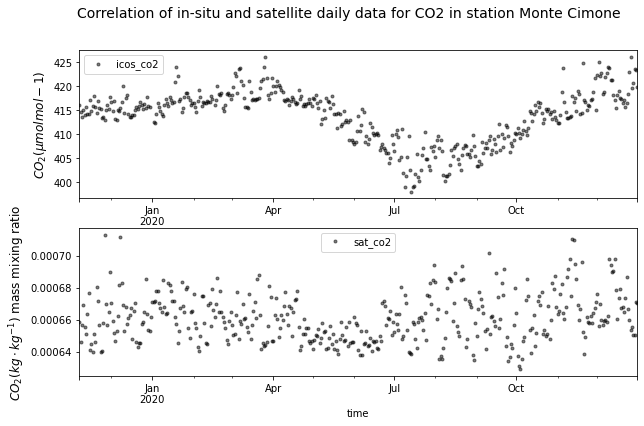

In [22]:
daily_icos = icos_df.set_index("time").resample('D').mean()
daily_sat = sat_df.set_index("time").resample('D').mean()

fig, axs = plt.subplots(nrows=2, figsize=(10,6))
daily_icos.plot(marker='.', alpha=0.5, color='k', linestyle='None', subplots=True, ax=axs[0])
daily_sat.plot(marker='.', alpha=0.5, color='k', linestyle='None', subplots=True, ax=axs[1])

if pollutant=="co2":
    axs[0].set_ylabel(fr'$CO_2 ({unit})$', fontsize=12)
    axs[1].set_ylabel(r'$CO_2 (kg \cdot kg^{-1})$ mass mixing ratio', fontsize=12)
elif pollutant=="co":
    axs[0].set_ylabel(fr'$CO ({unit})$', fontsize=12)
    axs[1].set_ylabel(r'$CO (\mu g \cdot m^{-3})$', fontsize=12)

fig.suptitle(f"Correlation of in-situ and satellite daily data for {pollutant.upper()} in station {icos_station}", fontsize=14)
plt.show()

In [23]:
monthly_icos = icos_df.set_index("time").resample('M').mean()
monthly_sat = sat_df.set_index("time").resample('M').mean()

fig, axs = plt.subplots(nrows=2, figsize=(10,6))
monthly_icos.plot(marker='.', alpha=0.5, color='k', linestyle='None', subplots=True, ax=axs[0])
monthly_sat.plot(marker='.', alpha=0.5, color='k', linestyle='None', subplots=True, ax=axs[1])

if pollutant=="co2":
    axs[0].set_ylabel(fr'$CO_2 ({unit})$', fontsize=12)
    axs[1].set_ylabel(r'$CO_2 (kg \cdot kg^{-1})$ mass mixing ratio', fontsize=12)
elif pollutant=="co":
    axs[0].set_ylabel(fr'$CO ({unit})$', fontsize=12)
    axs[1].set_ylabel(r'$CO (\mu g \cdot m^{-3})$', fontsize=12)

fig.suptitle(f"Correlation of in-situ and satellite monthly data for {pollutant.upper()} in station {icos_station}", fontsize=14)
plt.show()

In [24]:
# Compute the correlation (without removing the NULL data)
print('Monthly Corr: ' + str(monthly_sat[f"sat_{pollutant}"].corr(monthly_icos[f"icos_{pollutant}"])))
print('Daily Corr: ' + str(daily_sat[f"sat_{pollutant}"].corr(daily_icos[f"icos_{pollutant}"])))

Monthly Corr: 0.27657602182652463
Daily Corr: 0.03184398175057108


In [ ]:
# Correlation using the CORRCOEF (it supports NaN values in a numpy array)
from scipy.stats.stats import pearsonr  
import numpy as np 
from numpy import ma

np_SAT_monthly = monthly_sat[f"sat_{pollutant}"].values
np_ICOS_monthly = monthly_icos[f"icos_{pollutant}"].values
print("Corr concated: " + str(ma.corrcoef(ma.masked_invalid(np_SAT_monthly), ma.masked_invalid(np_ICOS_monthly))))

np_SAT_2 = np.concatenate((np_SAT_monthly, np_SAT_monthly))
np_ICOS_2 = np.concatenate((np_ICOS_monthly, np_ICOS_monthly))
print("Corr concated: " + str(ma.corrcoef(ma.masked_invalid(np_SAT_2), ma.masked_invalid(np_ICOS_2))) + "\n")

# 2 series plot
fig, axs = plt.subplots(nrows=1)
plt.plot(np_SAT_monthly, marker='.', alpha=1, color='k', linestyle='None')

In [ ]:
ts_ICOS_monthly = monthly_icos[f"icos_{pollutant}"]
ts_SAT_monthly = monthly_sat[f"sat_{pollutant}"]

In [ ]:
# Demonstration of the pairwise correlation excluding NaN by default of pandas
# We delete NaN from the list
ts_ICOS_monthly_notna = ts_ICOS_monthly[(ts_ICOS_monthly.notna() == True)]
ts_SAT_monthly_notna = ts_SAT_monthly[(ts_SAT_monthly.notna() == True)]
ts_index_monthly_notna = ts_SAT_monthly_notna.index.intersection(ts_ICOS_monthly_notna.index)
ts_ICOS_monthly_notna = ts_ICOS_monthly_notna.get(ts_index_monthly_notna)
ts_SAT_monthly_notna = ts_SAT_monthly_notna.get(ts_index_monthly_notna)

np_SAT_monthly_notna = ts_SAT_monthly_notna.values
np_ICOS_monthly_notna = ts_ICOS_monthly_notna.values
from scipy.stats.stats import pearsonr   
print("Monthly Corr: " + str(pearsonr(np_SAT_monthly_notna, np_ICOS_monthly_notna)))